Read data and filter 

Selected 859 points.
Selected 733 points from surface points as experiment zone


Text(0.5, 1.0, 'Extracted path')

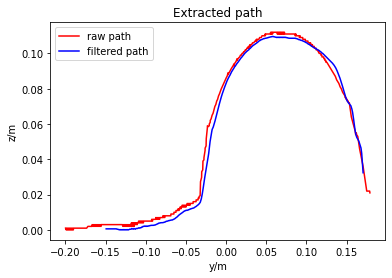

In [17]:
import numpy as np
import matplotlib.pyplot as plt

point = []
with open("data.txt") as data:
    for line in data.readlines():
        # print(line)
        line = line.replace('\n', '')
        line = line.split(' ')
        if float(line[1]) < 0.1:
            continue
        point.append([float(line[0]), float(line[1])])

path = np.array(point)
length = len(path)
print(f"Selected {length} points.")
y = path[:,0]
originalZ = path[:,1]

# moving average
windowSize = 10
filteredZ = np.convolve(originalZ, np.ones((windowSize,))/windowSize, mode='same')

# select smooth zone
start = -0.15
end = 0.175
trajectory = []

for i in range(len(y)):
    if y[i] < end and y[i] > start:
        # ## 原始点y方向间隔不一致
        trajectory.append([y[i], filteredZ[i]])
        # ## 近似改为间隔一致的y点

trajectory = np.array(trajectory)
trajectory[:,1] = trajectory[:,1].max() - trajectory[:,1]
# 将y改为间隔均匀的点
trajectory[:,0] = np.linspace(trajectory[:,0].min(), trajectory[:,0].max(), len(trajectory))
print(f"Selected {len(trajectory)} points from surface points as experiment zone")

rawZ = originalZ.max()-originalZ
plt.plot(y, rawZ, 'r')
plt.plot(trajectory[:, 0], trajectory[:,1], 'b')
plt.xlabel("y/m")
plt.ylabel("z/m")
plt.legend(['raw path', 'filtered path'])
plt.grid()
plt.title('Extracted path')

可以看到采取均匀间隔之后的曲线平滑了很多, 而且一阶导数也没有突变了, 这个数据应该是可以用的.

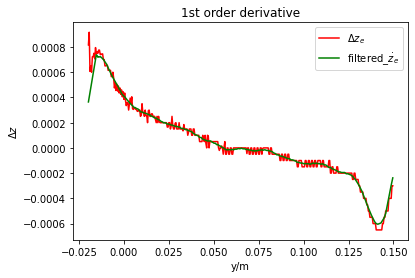

In [2]:
ze_dot = []
for i in range(len(trajectory)-1):
    # ze_d = (trajectory[i+1,1] - trajectory[i, 1]) / (trajectory[i+1,0] - trajectory[i,0])
    deltaZe = trajectory[i+1,1] - trajectory[i, 1]
    if abs(deltaZe) > 10:
        deltaZe = 0 
    # ze_dot.append([trajectory[i,0], ze_d])
    ze_dot.append(deltaZe)
ze_dot.append(ze_dot[-1])
ze_dot = np.array(ze_dot)
ze_dot_filtered = np.convolve(ze_dot, np.ones((20,))/20, mode="same")

plt.figure()
plt.xlabel("y/m")
plt.ylabel("$\Delta z$")
plt.title("1st order derivative")
plt.plot(trajectory[:,0], ze_dot, 'r')
plt.plot(trajectory[:,0], ze_dot_filtered, 'g')
plt.legend(["$\Delta z_e$", "filtered_$\dot z_e$"])

Text(0, 0.5, 'Force/ N')

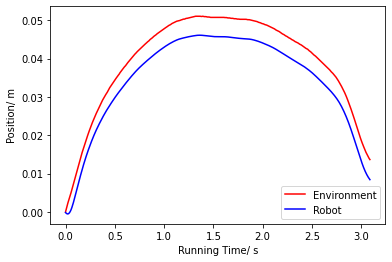

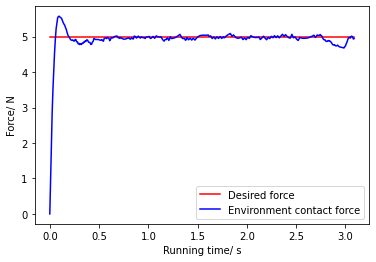

In [3]:
# impedance control parameters
m = 1       # kg
b = 50     # kg/s
k = 0
ke = 1000       # N/m   stiffness of environment model
dt = 0.008      # s sampling period

fd = 5  # N     Desired force
size = len(trajectory)
yDistance = trajectory[0,:].max() - trajectory[0,:].min()
step = yDistance / size
yVelocity = step / dt

x, xd, xdd =0, 0, 0     # initial value
# XE = np.linspace(0, 0.5, size)
XE = trajectory[:,1]
# XE = []
xed, xedd = 0, 0
# TODO: 没有规定y方向速度, 横轴不对
X, FE = [], []
# running
for i in range(size):
    xe = XE[i]
# environment derivatives
    # QUESTION: 为什么一阶差分跟踪的很好? (这是对时间的导数)
    # TODO: 可以采用更高级的数值微分方法,让曲线更加平滑
    # if i+1 < size:
    #     xed = (XE[i+1]-xe)/dt
    # else:
    #     xed = 0

    # QUESTION: 为什么预先算好的反而不对 ? 难道之前导数算错了? 这里是形状的导数(曲线切向量)
    # NOTE: 之前好像确实是导数算错了, 如果只用 deltaZ / step * V的话是正确的
    # xed = ze_dot[i,1] 
    xed = ze_dot_filtered[i] / step * yVelocity
    
    # xe = 0.5 * np.sin(i/1000 * np.pi)
    # XE.append(xe)

# contact force with the environment
    if x < xe:
        fe = ke * (xe - x)
    else:
        fe = 0

    FE.append(fe)
    xdd = xedd + 1/m * (-b * (xd - xed) - k*(x-xe) + fe - fd)
    xd = xd + xdd * dt
    x = x + xd * dt
    # if not (i%100):
    #     print(x)
    X.append(x)
    

xaxis = np.arange(size)*dt
plt.figure()
plt.plot(xaxis, XE, 'r')
plt.plot(xaxis, X, 'b')
plt.legend(["Environment", "Robot"])
plt.xlabel("Running Time/ s")
plt.ylabel("Position/ m")

plt.figure()
plt.plot(xaxis, np.ones((size,))*fd, 'r')
plt.plot(xaxis, FE, 'b')
plt.legend(["Desired force", "Environment contact force"])
plt.xlabel("Running time/ s")
plt.ylabel("Force/ N")

# Simulate 1-DOF impedance control on a slope
$$
e = x - x_e \\
m\ddot e + b\dot e + ke = f_e - f_d \\
\ddot x = \ddot x_e + 1/m(-b(\dot x - \dot x_e) - k(x-x_e) + f_e - f_d) \\
\dot x = \dot x(-1) + \ddot x \Delta t
$$


Text(0, 0.5, 'Force/ N')

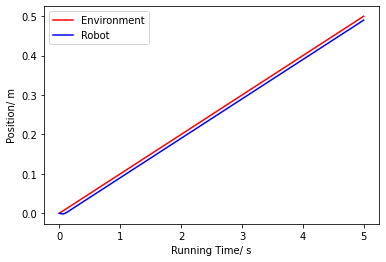

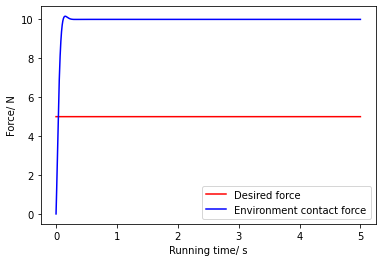

In [4]:
# impedance control parameters
m = 1       # kg
b = 50     # kg/s
k = 0
ke = 1000       # N/m   stiffness of environment model

fd = 5  # N     Desired force
size = 5000
dt = 0.001      # sampling period


x, xd, xdd =0, 0, 0     # initial value
XE = np.linspace(0, 0.5, size)
# XE = []
xed, xedd = 0, 0

X, FE = [], []
# running
for i in range(size):
    xe = XE[i]
    # xe = 0.5 * np.sin(i/1000 * np.pi)
    # XE.append(xe)
    # contact force with the environment
    if x < xe:
        fe = ke * (xe - x)
    else:
        fe = 0
    FE.append(fe)
    xdd = xedd + 1/m * (-b * (xd - xed) - k*(x-xe) + fe - fd)
    xd = xd + xdd * dt
    x = x + xd * dt
    # if not (i%100):
    #     print(x)
    X.append(x)
    

xaxis = np.arange(size)*dt
plt.figure()
plt.plot(xaxis, XE, 'r')
plt.plot(xaxis, X, 'b')
plt.legend(["Environment", "Robot"])
plt.xlabel("Running Time/ s")
plt.ylabel("Position/ m")

plt.figure()
plt.plot(xaxis, np.ones((size,))*fd, 'r')
plt.plot(xaxis, FE, 'b')
plt.legend(["Desired force", "Environment contact force"])
plt.xlabel("Running time/ s")
plt.ylabel("Force/ N")

# Simulate a robot under 1-DOF impedance control on extracted section